This response has been significantly modified from its original form. The flaws of my original response will be discussed below, but if you would like to see rouhgly what this response looked like before I made the big edit, take a look at the following notebook: https://nbviewer.jupyter.org/github/dmarx/data_generation_demo/blob/54be78fb5b68218971d2568f1680b4f783c0a79a/demo.ipynb

TL;DR: Use a KDE (or the procedure of your choice) to approximate $P(X)$, then use MCMC to draw samples from $P(X|Y) = P(Y|X)P(X)$, where $P(Y|X)$ is given by your model. From these samples, you can estimate the "optimal" $X$ by fitting a second KDE to the sampels you generated and selecting the observation that maximizes the KDE as your maximum a posteriori (MAP) estimate.

## Maximum Likelihood Estimation
### ... and why it doesn't work here

In my original response, the technique I suggested was to use MCMC to perform maximum likelihood estimation. Generally, MLE is a good approach to finding the "optimal" solutions to conditional probabilities, but we have a problem here: because we're using a discriminative model (a random forest in this case) our probabilities are being calculated relative to decision boundaries. It doesn't actually make sense to talk about an "optimal" solution to a model like this because once we get far enough away from the class boundary, the model will just predict ones or zeros for everything. If we have enough classes some of them might be completely "surrounded" in which case this won't be a problem, but classes on the boundary of our data will be "maximized" by values that aren't necessarily feasible.

To demonstrate, I'm going to leverage some convenience code you can find [here](https://github.com/dmarx/data_generation_demo/blob/master/generative_sampler.py), which provides the `GenerativeSampler` class which wraps code from my original response, some additional code for this better solution, and some additional features I was playing around with (some which work, some which don't) which I probably won't get into here.

In [1]:
from generative_sampler import GenerativeSampler

Additionally, instead of generating random high dimensional data, I'll use the iris data which is more familiar and easier to visualize.

In [2]:
    import time
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from sklearn.datasets import load_iris
    from sklearn.decomposition import PCA
    from sklearn.ensemble import RandomForestClassifier

    np.random.seed(123)

    iris = load_iris()
    X, y = iris.data, iris.target
    RFC = RandomForestClassifier(n_estimators=80, oob_score=True)
    _ = RFC.fit(X, y)

    pca = PCA(n_components=2)
    X_r = pca.fit_transform(X)

    #iris.target_names # 'setosa', 'versicolor', 'virginica'

Let's use MCMC with a gaussian random walk proposal to explore the distribution of observations which maximize the likelihood $P(Y=\text{'virginica'}|X)$ given by our random forest and see what happens by visualizing our sampling path plotted over the iris data. Full disclosure, I modified the likelihood slightly: rather than just using the raw probability scores given by the model, I collapse the score to near 0 if the model doesn't classify an observation according to our target class.

In [41]:
    np.random.seed(123)
    sampler = GenerativeSampler(model=RFC, X=X, y=y, 
                                target_class=2, 
                                prior=None, 
                                class_err_prob=0.05, # <-- the score we use for candidates that aren't predicted as the target class
                                rw_std=.05,          # <-- controls the step size of the random walk proposal
                                verbose=True, 
                                use_empirical=False)
    samples, _ = sampler.run_chain(n=5000)

[2018-01-04 17:41:55] Ensuring model fitted
[2018-01-04 17:41:55] Generating samples
[2018-01-04 17:41:55] Selecting an x0
[2018-01-04 17:41:55] Determining class_id
[2018-01-04 17:41:55] Ensuring model fitted


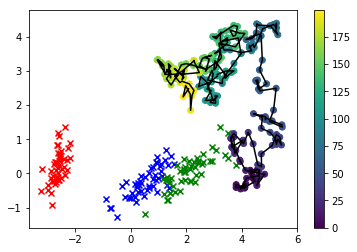

In [48]:
    burn = 1000
    thin = 20
    X_s = pca.transform(samples[burn::thin,:])

    # Plot the iris data
    col=['r','b','g']
    for i in range(3):
        plt.scatter(*X_r[y==i,:].T, c=col[i], marker='x')
    plt.plot(*X_s.T, 'k')
    plt.scatter(*X_s.T, c=np.arange(X_s.shape[0]))
    plt.colorbar()
    plt.show()

In this visualization, the x's are the real data, and the class we're interested in is green. The line-connected dots are the samples we drew, and their color corresponds to the order in which they were sampled, with their "thinned" sequence position given by the color bar label on the right.

As you can see, the sampler diverged from the data fairly quickly and then just basically hangs out pretty far away from values of the feature space that correspond to any real observations. Clearly this is a problem. 

One way we can cheat is to change our proposal function to only allow features to take values that we actually observed in the data. Let's try that and see how that changes the behavior of our result.

In [50]:
    np.random.seed(123)
    sampler = GenerativeSampler(model=RFC, X=X, y=y, 
                                target_class=2, 
                                prior=None, 
                                class_err_prob=0.05, 
                                verbose=True, 
                                use_empirical=True) # <-- magic happening under the hood
    samples, _ = sampler.run_chain(n=5000)

[2018-01-04 17:46:24] Ensuring model fitted
[2018-01-04 17:46:24] Generating samples
[2018-01-04 17:46:24] Selecting an x0
[2018-01-04 17:46:24] Determining class_id
[2018-01-04 17:46:24] Ensuring model fitted


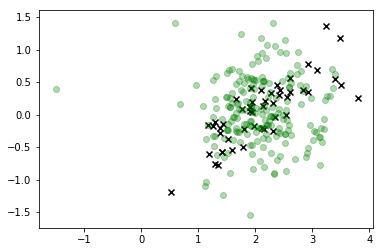

C:\Users\shagg\Anaconda3\lib\site-packages\seaborn\distributions.py:630: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


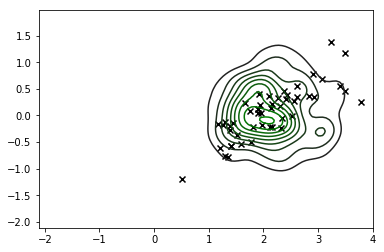

In [63]:
    X_s = pca.transform(samples[burn::thin,:])

    # Constrain attention to just the target class this time
    i=2
    plt.scatter(*X_r[y==i,:].T, c='k', marker='x')
    plt.scatter(*X_s.T, c='g', alpha=0.3)
    #plt.colorbar()
    plt.show()


    sns.kdeplot(X_s, cmap=sns.dark_palette('green', as_cmap=True))
    plt.scatter(*X_r[y==i,:].T, c='k', marker='x')
    plt.show()

This is definitely a significant improvement and the mode of our distribution corresponds roughly to what we're looking for, but it's clear we're still generating a lot of observations that don't correspond to feasible values of $X$ so we shouldn't really trust this distribution either. 

The obvious solution here is to incorporate $P(X)$ somehow to anchor our sampling process to regions of the feature space that the data is actually likely to take. So let's instead sample from the joint probability of the likelihood given by the model, $P(Y|X)$, and a numerical estimate for $P(X)$ given by a KDE fit on the entire dataset. So now we're... sampling from... $P(Y|X)P(X)$....

## Enter Bayes Rule

After you hounded me to be less hand-wavey with the math here, I played around with this a fair amount (hence me building the `GenerativeSampler` thing), and I encountered the problems I laid out above. I felt really, really stupid when I made this realization, but obviously what you are asking for calls for an application of Bayes rule and I apologize for being dismissive earlier. 

If you're not familiar with bayes rule, it looks like this:

$$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$$

In many applications the denominator is a constant which acts as a scaling term to ensure that the numerator integrates to 1, so the rule is often restated thusly:

$$P(B|A) \propto P(A|B)P(B)$$

Or in plain English: "the posterior is proportional to the prior times the likelihood".

Look familiar? How about now:

$$P(X|Y) \propto P(Y|X)P(X)$$

Yeah, this is exactly what we worked up to earlier by constructing an estimate for the MLE that is anchored to the observed distribution of the data. I've never thought about Bayes rule this way, but it makes sense so thank you for giving me the opportunity to discover this new perspective. 

To backtrack a tiny bit, MCMC is one of those applications of bayes rule where we can ignore the denominator. When we calculate the acceptanc ratio, $P(Y)$ will take the same value in both the numerator and denominator, canceling out, and allowing us to draw samples from unnormalized probability distributions.

So, having made this insight that we need to incorporate a prior for the data, let's do that by fitting a standard KDE and see how that changes our result.

In [3]:
    np.random.seed(123)
    sampler = GenerativeSampler(model=RFC, X=X, y=y, 
                                target_class=2, 
                                prior='kde',         # <-- the new hotness
                                class_err_prob=0.05,
                                rw_std=.05,          # <-- back to the random walk proposal
                                verbose=True, 
                                use_empirical=False)
    samples, _ = sampler.run_chain(n=5000)

[2018-01-04 18:15:14] Fitting kde  to approximate P(X)
[2018-01-04 18:15:14] Ensuring model fitted
[2018-01-04 18:15:14] Generating samples
[2018-01-04 18:15:14] Selecting an x0
[2018-01-04 18:15:14] Determining class_id
[2018-01-04 18:15:14] Ensuring model fitted


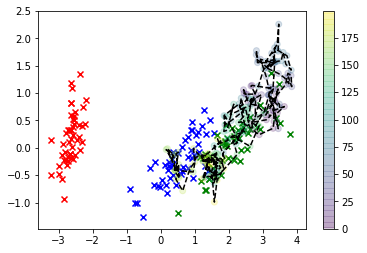

In [7]:
    burn = 1000
    thin = 20
    X_s = pca.transform(samples[burn::thin,:])

    # Plot the iris data
    col=['r','b','g']
    for i in range(3):
        plt.scatter(*X_r[y==i,:].T, c=col[i], marker='x')
    plt.plot(*X_s.T, 'k--')
    plt.scatter(*X_s.T, c=np.arange(X_s.shape[0]), alpha=0.2)
    plt.colorbar()
    plt.show()

Much better! Now, we can estimate your "optimal" $X$ value using what's called the "maximum a posteriori" estimate, which is a fancy way of saying we fit a second KDE -- but to our samples this time -- and find the value that maximizes the KDE, i.e. the value corresponding to the mode of $P(X|Y)$. I'm just going to pick the sample that has the highest score under the KDE, but you could take this a step further and use a separate optimization to find the value that maximizes the KDE.

[ 6.27039982  2.68840256  4.93024383  1.96223785]


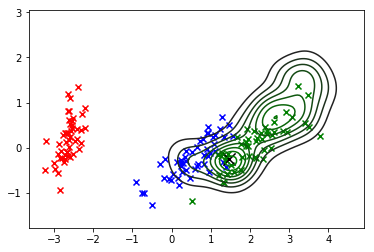

In [65]:
    # MAP estimation

    from sklearn.neighbors import KernelDensity
    from sklearn.model_selection import GridSearchCV
    from scipy.optimize import minimize

    grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.1, 1.0, 30)}, cv=10, refit=True)
    kde = grid.fit(samples[burn::thin,:]).best_estimator_

    def map_objective(x):
        try:
            score = kde.score_samples(x)
        except ValueError:
            score = kde.score_samples(x.reshape(1,-1))
        return -score

    x_map = minimize(map_objective, samples[-1,:].reshape(1,-1)).x

    print(x_map)

    x_map_r = pca.transform(x_map.reshape(1,-1))[0]
    col=['r','b','g']
    for i in range(3):
        plt.scatter(*X_r[y==i,:].T, c=col[i], marker='x')
    sns.kdeplot(*X_s.T, cmap=sns.dark_palette('green', as_cmap=True))
    plt.scatter(x_map_r[0], x_map_r[1], c='k', marker='x', s=150)
    plt.show()

And there you have it: 'X' marks the spot.